Confusion matrix:
 [[19  0  0]
 [ 0 15  0]
 [ 0  2 14]]


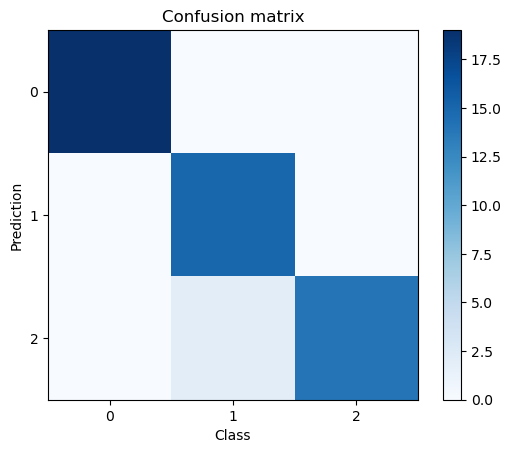

Classification accuracy:  0.96
Confusion matrix:
 [[19  0  0]
 [ 0 16  0]
 [ 0  1 14]]


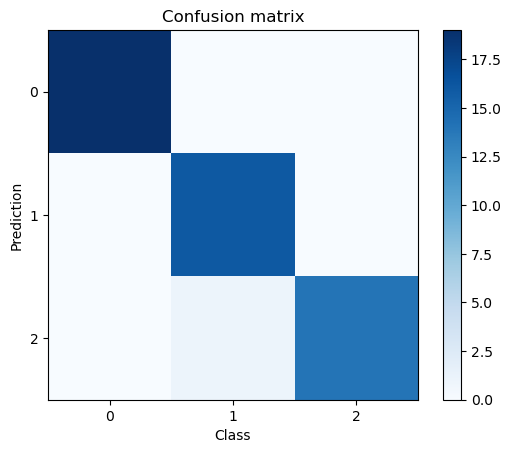

Classification accuracy:  0.98


In [116]:
import sklearn.datasets
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from matplotlib.colors import LogNorm
import scipy



def load_iris():
    D,L = sklearn.datasets.load_iris()['data'].T, sklearn.datasets.load_iris()['target']
    return D, L

D, L = load_iris()

def split_train(D, L, percentageTraining, seed=0):
    nTrain = int(D.shape[1] * percentageTraining)
    np.random.seed(seed)
    shuffledIndices = np.random.permutation(D.shape[1])

    DTR = D[:, shuffledIndices[0:nTrain]]
    LTR = L[shuffledIndices[0:nTrain]]

    DVAL = D[:, shuffledIndices[nTrain:]]
    LVAL = L[shuffledIndices[nTrain:]]

    return (DTR, LTR), (DVAL, LVAL)




def calc_params(D):
    U = D.mean(axis=1, keepdims=True)
    z = D - U
    C = z @ z.T / D.shape[1]

    return U, C


def logpdf_GAU_ND(X, mu, C):
    """
    Calculates the log of the probability density function of a multivariate Gaussian distribution.
    """
    _, C_logdet = np.linalg.slogdet(C)
    C_inv = np.linalg.inv(C)
    dotp = 0.5 * np.sum((X - mu) * (C_inv @ (X - mu)), axis=0)

    return -C.shape[0]/2 * np.log(2*np.pi) - 0.5 * C_logdet - dotp

def confusion_matrix(predicted, LVAL, **kwargs):
    classes = np.unique(LVAL)
    n_classes = len(classes)
    confusion_matrix = np.zeros((n_classes, n_classes), dtype=int)
    for i in range(len(predicted)):
        confusion_matrix[predicted[i], LVAL[i]] += 1

    if not 'skip_plot' in kwargs:
        print("Confusion matrix:\n", confusion_matrix)
        # Plotting the confusion matrix
        plt.imshow(confusion_matrix, interpolation='nearest', cmap=plt.cm.Blues)
        plt.title('Confusion matrix')
        plt.colorbar()
        tick_marks = np.arange(n_classes)
        plt.xticks(tick_marks, np.arange(n_classes))
        plt.yticks(tick_marks, np.arange(n_classes))
        plt.xlabel('Class')
        plt.ylabel('Prediction')
        plt.show()

    return confusion_matrix

def classify_log_pdf(D, L):
    (DTR, LTR), (DVAL, LVAL) = split_train(D, L, 2.0/3.0, seed=0)

    def params_func(DTR, LTR):
        return [calc_params(DTR[:, (LTR == l)]) for l in np.unique(LTR)]
    params_by_class = params_func(DTR, LTR)
    Pc = 1/3
    logSJoint = np.array([logpdf_GAU_ND(DVAL, params[0], params[1]) + np.log(Pc) for params in params_by_class])

    logSMarginal = scipy.special.logsumexp(logSJoint, axis=0).reshape(1, -1)
    logSPost = logSJoint - logSMarginal

    predicted = np.argmax(np.exp(logSPost), axis=0)

    confusion_matrix(predicted, LVAL)


    # Model evaluation
    print("Classification accuracy: ", np.mean(predicted == LVAL))

classify_log_pdf(D, L)

def classify_log_pdf_tied(D, L):
    (DTR, LTR), (DVAL, LVAL) = split_train(D, L, 2.0/3.0, seed=0)

    def params_func(DTR, LTR):
        params_by_class = []
        C_tied = np.zeros((DTR.shape[0], DTR.shape[0]))
        for l in np.unique(LTR):
            Dl = DTR[:, (LTR == l)]
            U = Dl.mean(axis=1, keepdims=True)
            z = Dl - U
            C_tied += z @ z.T
            params_by_class.append((U, 0))
        C_tied = C_tied / DTR.shape[1]
        for l in range(len(params_by_class)):
            params_by_class[l] = (params_by_class[l][0], C_tied)
        return params_by_class
    params_by_class = params_func(DTR, LTR)

    Pc = 1/3
    logSJoint = np.array([logpdf_GAU_ND(DVAL, params[0], params[1]) + np.log(Pc) for params in params_by_class])

    logSMarginal = scipy.special.logsumexp(logSJoint, axis=0).reshape(1, -1)
    logSPost = logSJoint - logSMarginal

    predicted = np.argmax(np.exp(logSPost), axis=0)
    
    confusion_matrix(predicted, LVAL)

    # Model evaluation
    print("Classification accuracy: ", np.mean(predicted == LVAL))

classify_log_pdf_tied(D, L)

# Divine commedy

Confusion matrix:
 [[210 113  61]
 [137 191 111]
 [ 53  98 230]]


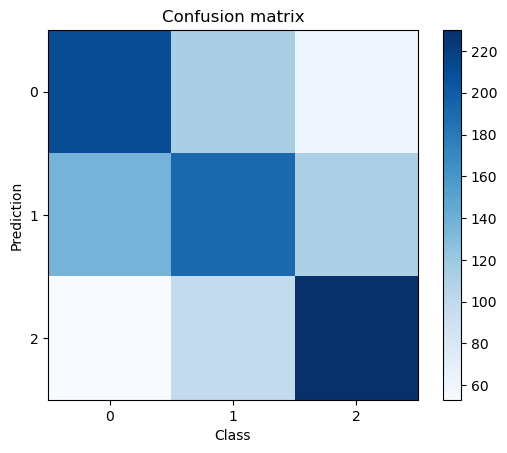

In [117]:
labels = np.load("Dante/commedia_labels.npy")
ll = np.load("Dante/commedia_ll.npy")

predicted = np.argmax(ll, axis=0)
CM = confusion_matrix(predicted, labels)

# Binary Bayes cost

(802,)
Classification accuracy:  0.7443890274314214
Confusion matrix:
 [[293  96]
 [109 304]]


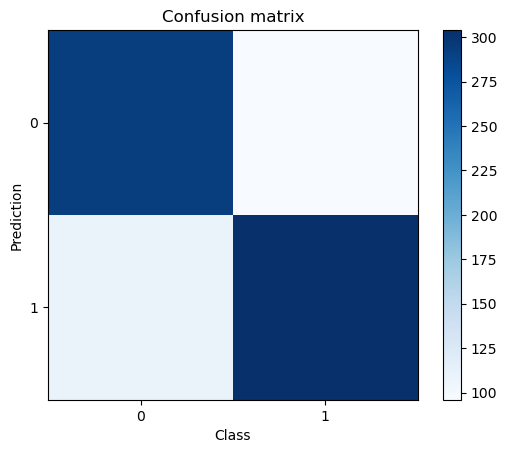

Classification accuracy:  0.7369077306733167
Confusion matrix:
 [[271  80]
 [131 320]]


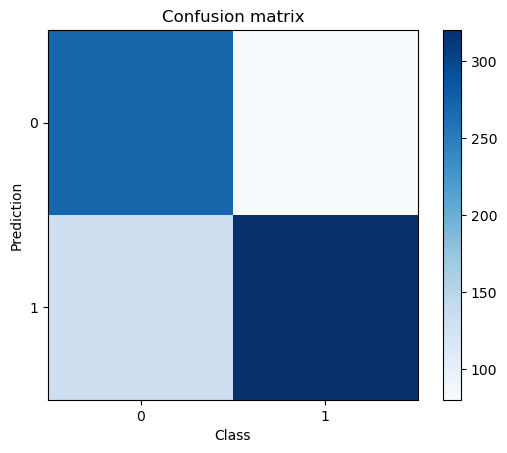

Classification accuracy:  0.7256857855361596
Confusion matrix:
 [[257  75]
 [145 325]]


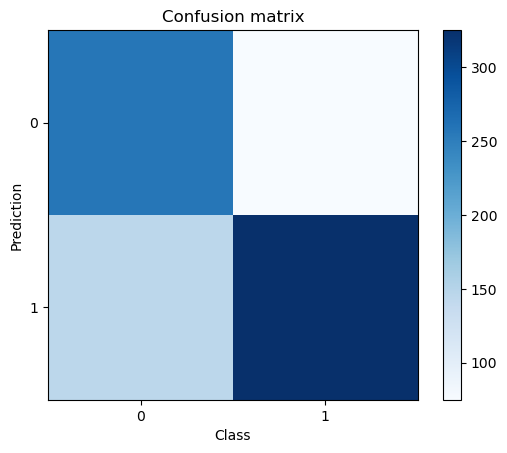

Classification accuracy:  0.7344139650872819
Confusion matrix:
 [[302 113]
 [100 287]]


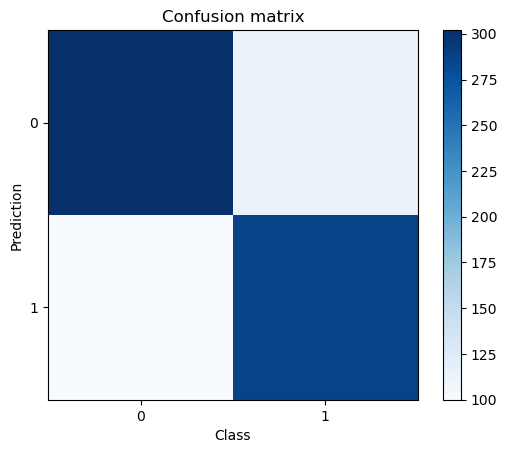

Costs with unnormalized confusion matrix:
[0.25557214 0.22517413 1.11784826 0.72351244]
Costs with normalized confusion matrix:
[0.51114428 1.12587065 2.23569652 0.90439055]
Minimum costs:
[0.50864428 0.76154229 0.86654229 0.70931592]


In [138]:
L = np.load("Dante/commedia_labels_infpar.npy")
llr = np.load("Dante/commedia_llr_infpar.npy")
print(llr.shape)

def classify_with_bayes_cost(pi1, Cfn, Cfp, **kwargs):
    C = np.zeros((2,2))
    C[0,1] = Cfn
    C[1,0] = Cfp

    if "llr" in kwargs:
        chosen_llr = kwargs["llr"]
    else:
        chosen_llr = llr 
    t = -np.log(pi1 * Cfn / ((1 - pi1) * Cfp))
    predicted = chosen_llr > t
    predicted = predicted.astype(int)
    print("Classification accuracy: ", np.mean(predicted == L))
    CM = confusion_matrix(predicted, L, **kwargs)
    return CM

def DFCu(pi1, Cfn, Cfp, confusion_matrix):
    Pfn = confusion_matrix[0, 1] / np.sum(confusion_matrix[:, 1])
    Pfp = confusion_matrix[1, 0] / np.sum(confusion_matrix[:, 0])
    return pi1 * Cfn * Pfn + (1 - pi1) * Cfp * Pfp

def DFC(pi1, Cfn, Cfp, confusion_matrix):
    Bdummy = min(pi1 * Cfn, ((1 - pi1) * Cfp))
    return DFCu(pi1, Cfn, Cfp, confusion_matrix) / Bdummy

def minDFC(pi1, Cfn, Cfp, L, llr):
    thresholds = np.array(sorted(list(enumerate(llr)), key=lambda x: x[1], reverse=True))
    thresholds = np.concatenate(([(-1, np.inf)], thresholds, [(-1, -np.inf)]))

    predicted = np.zeros(len(llr), dtype=np.int64)
    current_min = np.inf
    for i, t in thresholds:
        CM = confusion_matrix(predicted, L, skip_plot=True)
        c = DFC(pi1, Cfn, Cfp, CM)
        if c < current_min:
            current_min = c
        if i > 0:
            predicted[int(i)] = 1

    return current_min



table = [(0.5, 1, 1), (0.8, 1, 1), (0.5, 10, 1), (0.8, 1, 10)]
costs_u = np.zeros(len(table))
costs = np.zeros(len(table))
min_costs = np.zeros(len(table))
for i, (pi1, Cfn, Cfp) in enumerate(table):
    CM = classify_with_bayes_cost(pi1, Cfn, Cfp)
    costs_u[i] = DFCu(pi1, Cfn, Cfp, CM)
    costs[i] = DFC(pi1, Cfn, Cfp, CM)
    min_costs[i] = minDFC(pi1, Cfn, Cfp, L, llr)
    

print("Costs with unnormalized confusion matrix:")
print(costs_u)
print("Costs with normalized confusion matrix:")
print(costs)
print("Minimum costs:")
print(min_costs)

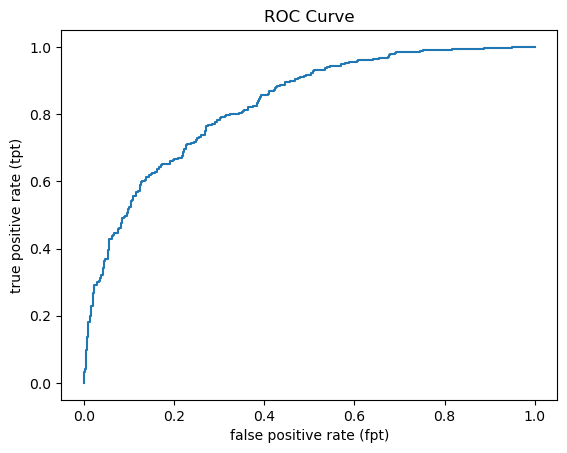

In [119]:
def ROCcurve():
    thresholds = np.array(sorted(llr))
    thresholds = np.concatenate(([-np.inf], thresholds, [np.inf]))

    fpr = np.zeros(len(thresholds))
    tpr = np.zeros(len(thresholds))
    for i, t in enumerate(thresholds):
        predicted = llr > t
        predicted = predicted.astype(int)
        
        CM = confusion_matrix(predicted, L, skip_plot=True)
        Pfn = CM[0, 1] / np.sum(CM[:, 1])
        Pfp = CM[1, 0] / np.sum(CM[:, 0])
        
        # Calculate the false positive rate and true positive rate
        fpr[i] = Pfp
        tpr[i] = 1 - Pfn
    plt.plot(fpr, tpr)
    plt.title("ROC Curve")
    plt.xlabel("false positive rate (fpt)")
    plt.ylabel("true positive rate (tpt)")
        
ROCcurve()

In [124]:
effPriorLogOdds = np.linspace(-3, 3, 21)
effPrior = 1/(1 + np.exp(-effPriorLogOdds))
dcf_with_prior = np.array([DFC(pi1, 1, 1, classify_with_bayes_cost(pi1, 1, 1,skip_plot=True)) for pi1 in effPrior])
mindcf_with_prior = np.array([minDFC(pi1, 1, 1, L, llr) for pi1 in effPrior])

llr_eps1 = np.load("Dante/commedia_llr_infpar_eps1.npy")
dcf_with_prior_eps1 = np.array([DFC(pi1, 1, 1, classify_with_bayes_cost(pi1, 1, 1,skip_plot=True, llr=llr_eps1)) for pi1 in effPrior])
mindcf_with_prior_eps1 = np.array([minDFC(pi1, 1, 1, llr_eps1) for pi1 in effPrior])


plt.plot(effPriorLogOdds, mindcf_with_prior, color='b')
plt.plot(effPriorLogOdds, dcf_with_prior, color='r')


plt.plot(effPriorLogOdds, mindcf_with_prior_eps1)
plt.plot(effPriorLogOdds, dcf_with_prior_eps1)

plt.ylim([0, 1.1])
plt.xlim([-3, 3])

Classification accuracy:  0.7356608478802993
Classification accuracy:  0.7331670822942643
Classification accuracy:  0.729426433915212
Classification accuracy:  0.729426433915212
Classification accuracy:  0.7344139650872819
Classification accuracy:  0.7369077306733167
Classification accuracy:  0.7381546134663342
Classification accuracy:  0.7356608478802993
Classification accuracy:  0.7356608478802993
Classification accuracy:  0.7356608478802993
Classification accuracy:  0.7443890274314214
Classification accuracy:  0.743142144638404
Classification accuracy:  0.7406483790523691
Classification accuracy:  0.7394014962593516
Classification accuracy:  0.7369077306733167
Classification accuracy:  0.7344139650872819
Classification accuracy:  0.7256857855361596
Classification accuracy:  0.7281795511221946
Classification accuracy:  0.726932668329177
Classification accuracy:  0.7256857855361596
Classification accuracy:  0.7244389027431422


IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

Confusion matrix:
 [[205 111  56]
 [145 199 121]
 [ 50  92 225]]


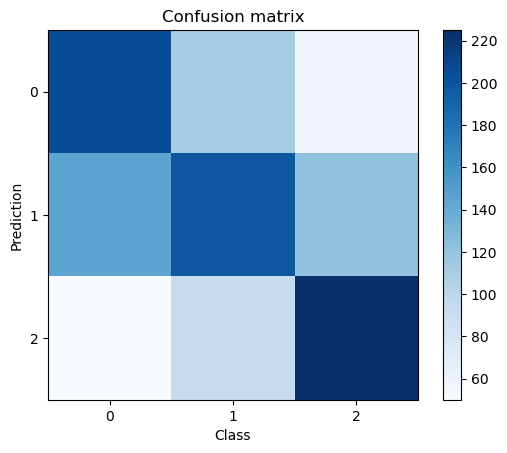

[[0.         0.2761194  0.13930348]
 [0.3625     0.         0.30099502]
 [0.125      0.22885572 0.        ]]
0.5596206467661692 0.9327010779436153
Confusion matrix:
 [[216  77  31]
 [146 236 143]
 [ 38  89 228]]


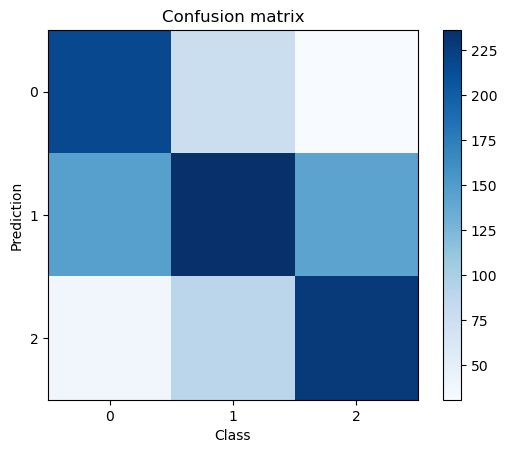

[[0.         0.19154229 0.07711443]
 [0.365      0.         0.35572139]
 [0.095      0.22139303 0.        ]]
0.48465920398009943 0.8077653399668324
Confusion matrix:
 [[210 113  61]
 [137 191 111]
 [ 53  98 230]]


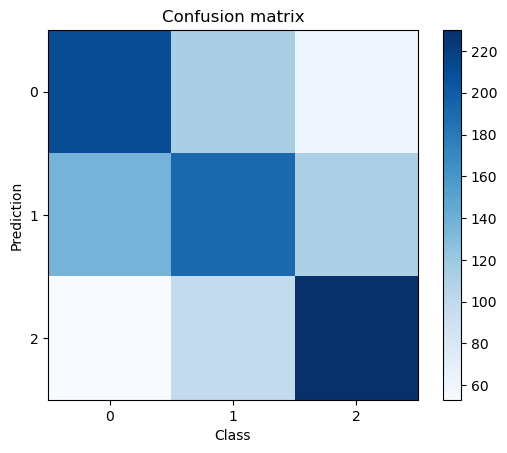

[[0.         0.28109453 0.15174129]
 [0.3425     0.         0.2761194 ]
 [0.1325     0.24378109 0.        ]]
0.4759121061359867 0.7138681592039802
Confusion matrix:
 [[245  96  51]
 [107 203  95]
 [ 48 103 256]]


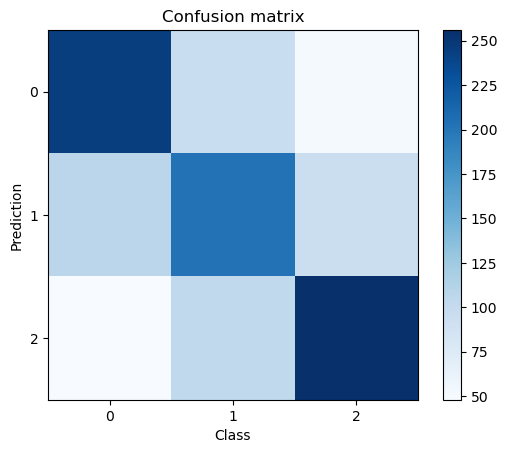

[[0.         0.23880597 0.12686567]
 [0.2675     0.         0.23631841]
 [0.12       0.25621891 0.        ]]
0.41523631840796016 0.6228544776119402


In [121]:
ll = np.load("Dante/commedia_ll.npy")
labels = np.load("Dante/commedia_labels.npy")

C = np.array([[0, 1, 2], [1, 0, 1], [2, 1, 0]])
pi = np.array([0.3, 0.4, 0.3])


def multi_DFCu(optimal, labels, pi, C):
    CM = confusion_matrix(optimal, labels)
    misclass_ratio = np.zeros((C.shape[0], C.shape[1]))
    for i in range(C.shape[0]):
        for j in range(C.shape[1]):
            if i != j:
                misclass_ratio[i, j] = CM[i,j] / np.sum(CM[:, j])
    print(misclass_ratio)
    return pi @ np.sum(misclass_ratio * C, axis=0)


P = pi.reshape((-1, 1)) * np.exp(ll)
CP = C @ P
optimal = np.argmin(CP, axis=0)

Cp = C @ pi

dummy_cost = np.min(Cp)
res_DCFu = multi_DFCu(optimal, labels, pi, C)
print(res_DCFu, res_DCFu/dummy_cost)


ll_eps1 = np.load("Dante/commedia_ll_eps1.npy")
labels_eps1 = np.load("Dante/commedia_labels_eps1.npy")
P = pi.reshape((-1, 1)) * np.exp(ll_eps1)
CP = C @ P
optimal = np.argmin(CP, axis=0)

Cp = C @ pi

dummy_cost = np.min(Cp)
res_DCFu = multi_DFCu(optimal, labels_eps1, pi, C)
print(res_DCFu, res_DCFu/dummy_cost)


# repeat with different cost matrix
C = np.array([[0, 1, 1], [1, 0, 1], [1, 1, 0]])
pi = np.array([1/3, 1/3, 1/3])


P = pi.reshape((-1, 1)) * np.exp(ll)
CP = C @ P
optimal = np.argmin(CP, axis=0)

Cp = C @ pi

dummy_cost = np.min(Cp)
res_DCFu = multi_DFCu(optimal, labels, pi, C)
print(res_DCFu, res_DCFu/dummy_cost)


ll_eps1 = np.load("Dante/commedia_ll_eps1.npy")
labels_eps1 = np.load("Dante/commedia_labels_eps1.npy")
P = pi.reshape((-1, 1)) * np.exp(ll_eps1)
CP = C @ P
optimal = np.argmin(CP, axis=0)

Cp = C @ pi

dummy_cost = np.min(Cp)
res_DCFu = multi_DFCu(optimal, labels_eps1, pi, C)
print(res_DCFu, res_DCFu/dummy_cost)
